# RUN experiments

In this notebook, we will run all the required experiments using the `Experiment` class, which can be found at `sscode/experiment.py`, and can be seen below:

```python
    class Experiment(object):
        """
        This class Experiment summarizes all the previous work done with the linear and the
        knn models, as this class allows the user to perform a detailed analysis of one
        requested model given a set of parameters

        """

        def __init__(self, slp_data, wind_data, ss_data, # this must have several stations
                     sites_to_analyze: list = list(np.random.randint(10,1000,5)),
                     model: str = 'linear', # this is the model to analyze
                     model_metrics: list = [
                         'bias','si','rmse','pearson','spearman','rscore',
                         'mae', 'me', 'expl_var', # ...
                     ], # these are the metrics to evaluate
                     pca_attrs: dict = pca_attrs_default,
                     model_attrs: dict = linear_attrs_default):
            """
            As the initializator, the __init__ funciton creates the instance of the class,
            given a set of parameters, which are described below

            Args:
                slp_data (xarray.Dataset): These are the sea-level-pressure fields, previously
                    loaded with the Loader class, loader.predictor_slp!!
                wind_data (xarray.Dataset): These are the wind fields, previously
                    loaded with the Loader class, loader.predictor_wind!!
                ss_data (xarray.Dataset): This is the storm surge from the moana hindcast, previously
                    loaded with the Loader class, loader.predictand!!
                sites_to_analyze (list, optional): This is the list with all the moana v2
                    hindcast locations to analyze. Defaults to random locations.
                model (str, optional): Type of model to analyze. Defaults to 'linear'.
                model_metrics (list, optional): These are all the evaluation metrics that might
                    be used to evaluate the model performance. Defaults to simple list.
                pca_attrs (dict, optional): PCA dictionary with all the parameters to use.
                    Defaults to pca_attrs_default.
                model_attrs (dict, optional): Model dictionary with all the parameters to use. 
                    Defaults to linear_attrs_default.
            """

            # lets build the experiment!!
```

where it can be seen how, given the sea-level-pressure / wind data, the storm surge (it is preferable to use the Moana v2 hindcast nearshore), all the individual sites to analyze, the type of model that will be used (with its evaluation metrics), and the PCA attributes and the MODEL attributes that will be used to calculate the model.

Given these parameters, we construct the object of the class, and then running `execute_cross_model_calculations`, we can perform all the experiments given the possible combinations!!

```{warning}
Be careful with the ["curse of dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality), as it seems very easy to add more options for the parameters of the models, but once we have more than 3-4 parameters with 2-3 different values, the number of models that will be performed can increase to hundreds!!
```

Below, different code cells with imports, loading functions, visualizations... will appear, but thw worflow is similar to all the notebooks in the repository. Once we load the data, we use the pre-built python classes to generate results!!

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import data_path, default_location, \
    default_region, default_region_reduced
from sscode.data import Loader
from sscode.experiment import Experiment

# warnings
import warnings
warnings.filterwarnings('ignore')

# for autocomplete code
%config Completer.use_jedi = False

## Load the data, SLP and SS

Below, we load the slp fields and the Moana v2 hindcast data nearshore. Have three things in mind:

* First, the winds are **NOT** loaded, as we prefer to calculate the gradient of the slp fields. Having in mind that winds have more resolution (more computation is required) and the fact that we are playing around with projected winds, adds this new calculation to each step (and the Loader class is calculated outside the class Experiment, so the projedted winds are calculated just to one location).

* The `plot` parameter is set to `False`, but can be set to `True` if all the plots are wanted to be seen.

* The Moana v2 hindcast nearshore is used, and although the gridded netCDF data can be used, which includes ss data all over the New Zealand region, the data might be transformed to `dim=site` inside the dataset, as we did in previous notebooks.

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False, 
    time_resample='1D', load_winds=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



## Create / Run -- Experiment object

In the two cells below, we first choose all the values that will have the different parameters for the model that will be used, and then we create the instance of the class `Experiment`, where different logs will appear before running all the models.

In [3]:
# experiment attributes
# ---------------------

sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)
pca_attrs_exp = {
    'calculate_gradient': [False,True],
    'winds': [False],
    'time_lapse': [1,2], # 1 equals to NO time delay 
    'time_resample': ['1D'], # 6H and 12H available...
    'region': [('local',(2.6,2.6))]
}
linear_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98]
}
knn_attrs_exp = {
    'train_size': [0.7], 'percentage_PCs': [0.98],
    'k_neighbors': [3,6,9] # None calculates the optimum k-neighs
}

```{note}
Please check `Experiment` logs before running `execute_cross_model_calculations()`!!
```

In [4]:
# create the experiment
experiment = Experiment(
    load_cfsr_moana_uhslc.predictor_slp, None,
    # load_cfsr_moana_uhslc.predictor_wind,
    load_cfsr_moana_uhslc.predictand, # all the sites are passed to exp at first
    sites_to_analyze=sites_to_analyze[:2], 
    model='linear', # model that will be used to predict
    model_metrics=['expl_var','mae','mse','me',
        'medae','tweedie', # check theory
        'ext_mae','ext_mse','ext_rmse','ext_pearson',
        'bias','si','rmse','pearson','spearman','rscore'
    ],
    pca_attrs=pca_attrs_exp,
    model_attrs=linear_attrs_exp
)


 The model has been correctly initialized with || model = linear ||             

 and model evaluation metrics = ['expl_var', 'mae', 'mse', 'me', 'medae', 'tweedie', 'ext_mae', 'ext_mse', 'ext_rmse', 'ext_pearson', 'bias', 'si', 'rmse', 'pearson', 'spearman', 'rscore']             

 pca_params = {'calculate_gradient': [False, True], 'winds': [False], 'time_lapse': [1, 2], 'time_resample': ['1D'], 'region': [('local', (2.6, 2.6))]} 

 model_params = {'train_size': [0.7], 'percentage_PCs': [0.98]}             

 which makes a total of 4 iterations as there are (2, 1, 2, 1, 1, 1, 1) values for each parameter             

 the experiment will be performed in sites = [116 200]             

 RUN CELL BELOW if this information is correct!!


```{note}
Once the instance of the class is well created, lets run all the models running the cell below
```


 ---------------------------------------------------------                         

 Experiment 1 in site 116 ......                         

 pca_params = {'calculate_gradient': False, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculated PCs matrix with shape: 
 (11353, 100) 


 plotting 1 components with 1 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



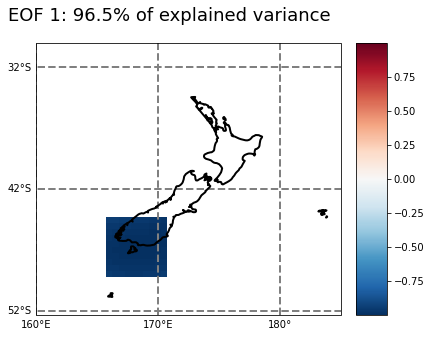

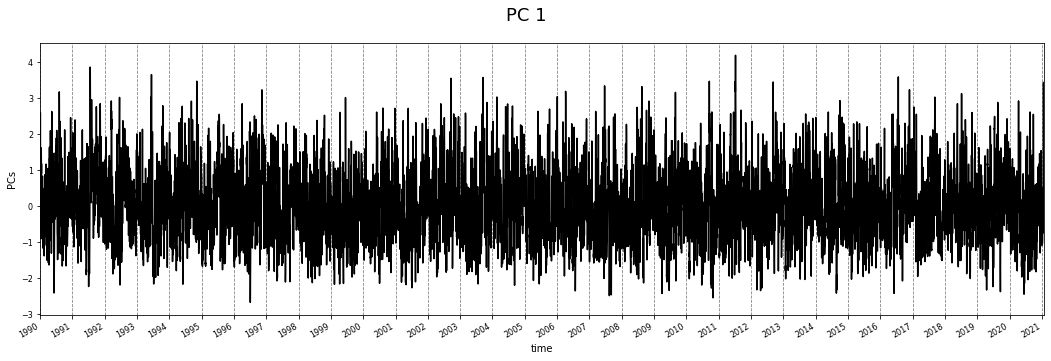


 3 PCs (0.98 expl. variance) will be used to train the model!! 



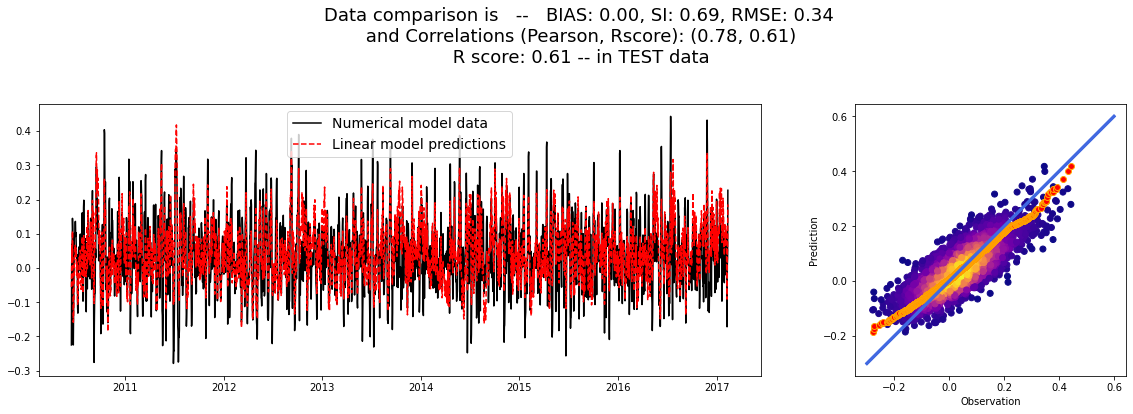

Data comparison is   --   BIAS: 0.00, SI: 0.69, RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 2 in site 116 ......                         

 pca_params = {'calculate_gradient': False, 'winds': False, 'time_lapse': 2, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 1, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculated PCs matrix with shape: 
 (11352, 200) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



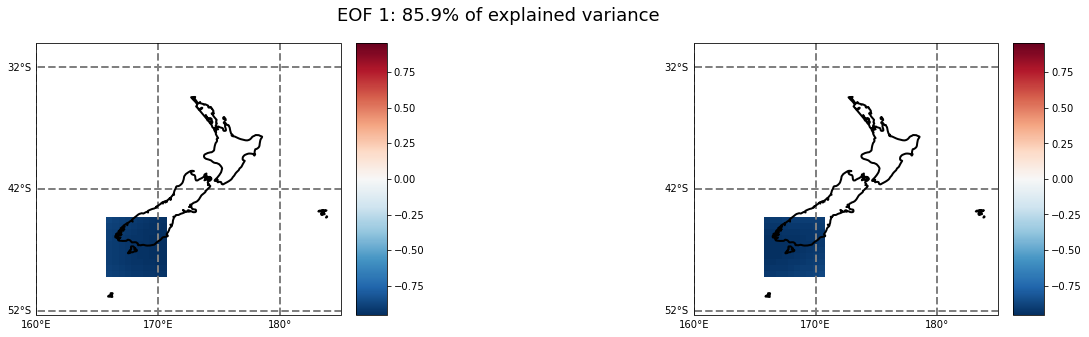

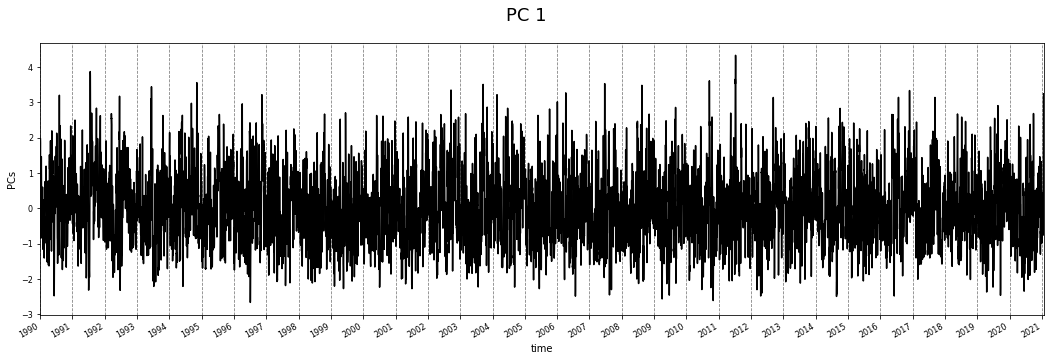


 3 PCs (0.98 expl. variance) will be used to train the model!! 



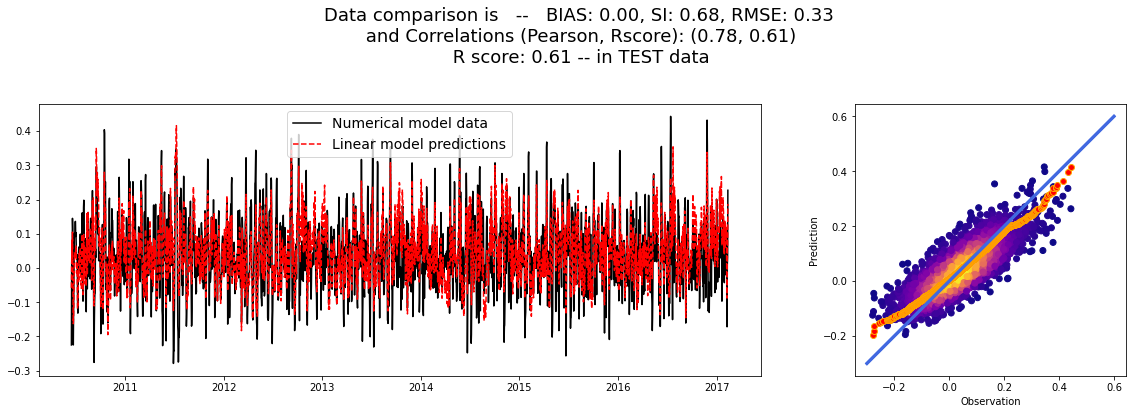

Data comparison is   --   BIAS: 0.00, SI: 0.68, RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 3 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (1, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculated PCs matrix with shape: 
 (11353, 200) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



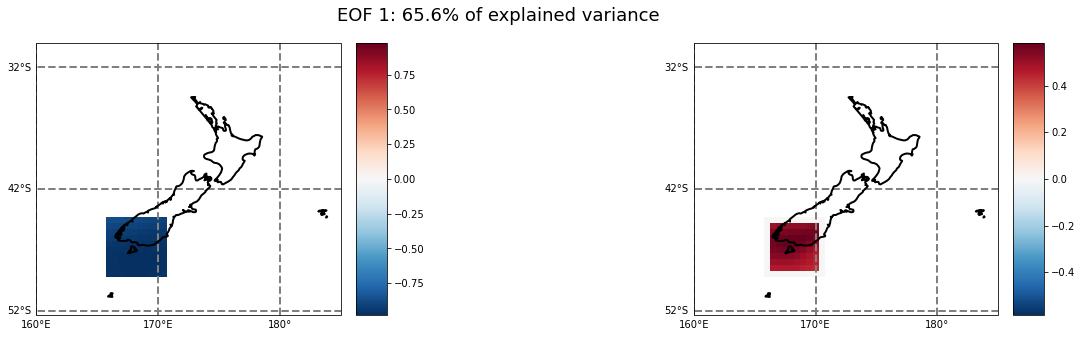

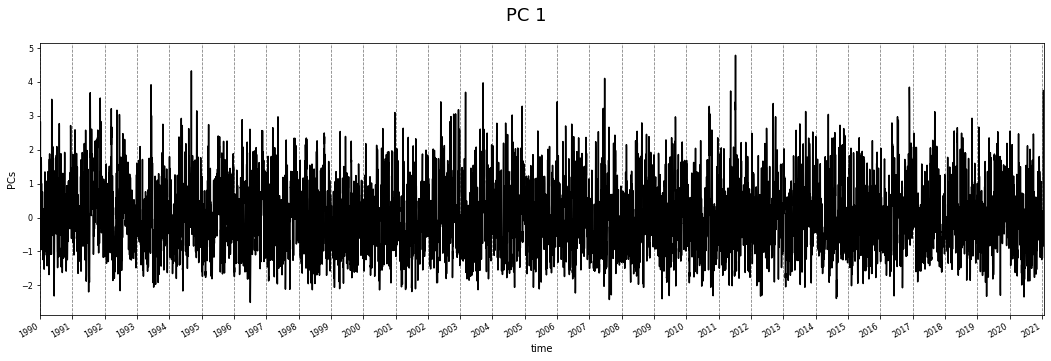


 5 PCs (0.98 expl. variance) will be used to train the model!! 



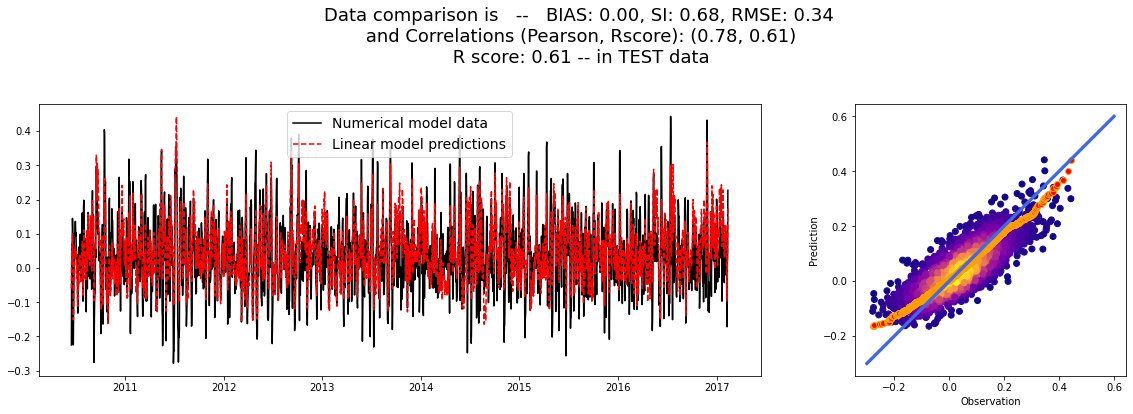

Data comparison is   --   BIAS: 0.00, SI: 0.68, RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 R score: 0.61 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 4 in site 116 ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 2, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (1, 0, 1, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculated PCs matrix with shape: 
 (11352, 400) 


 plotting 1 components with 4 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



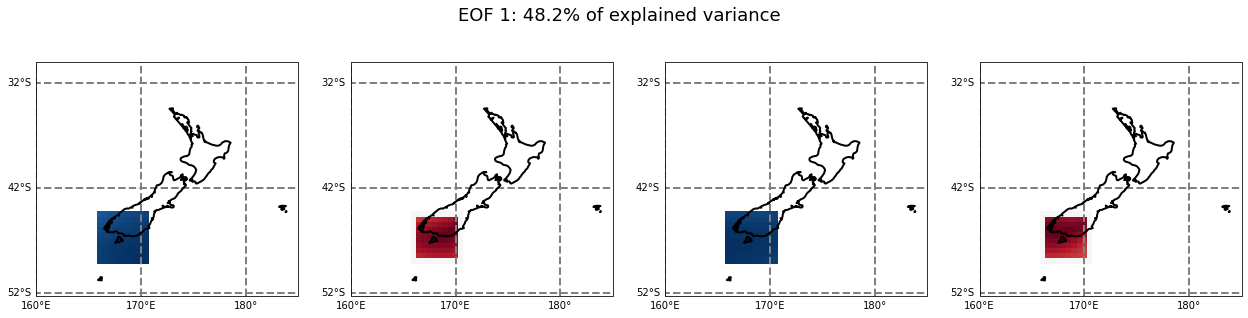

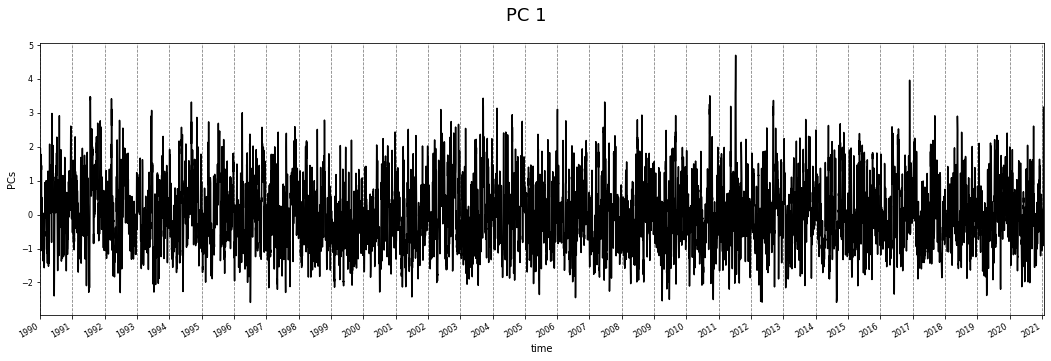


 9 PCs (0.98 expl. variance) will be used to train the model!! 



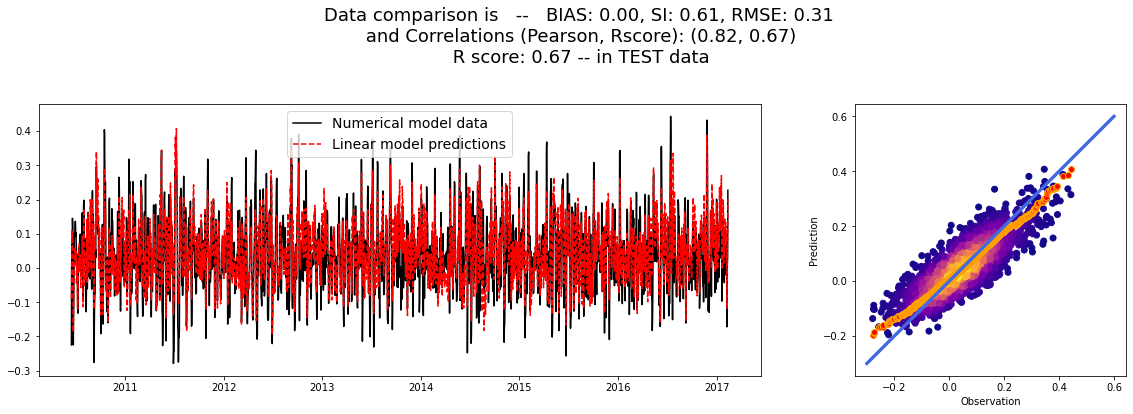

Data comparison is   --   BIAS: 0.00, SI: 0.61, RMSE: 0.31
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 R score: 0.67 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 1 in site 200 ......                         

 pca_params = {'calculate_gradient': False, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculated PCs matrix with shape: 
 (11353, 121) 


 plotting 1 components with 1 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



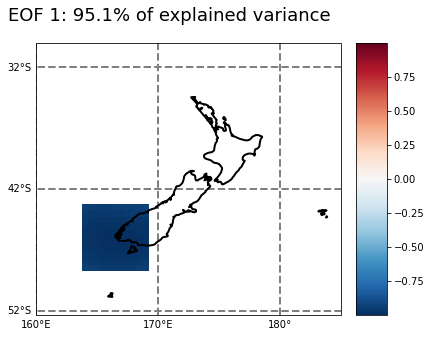

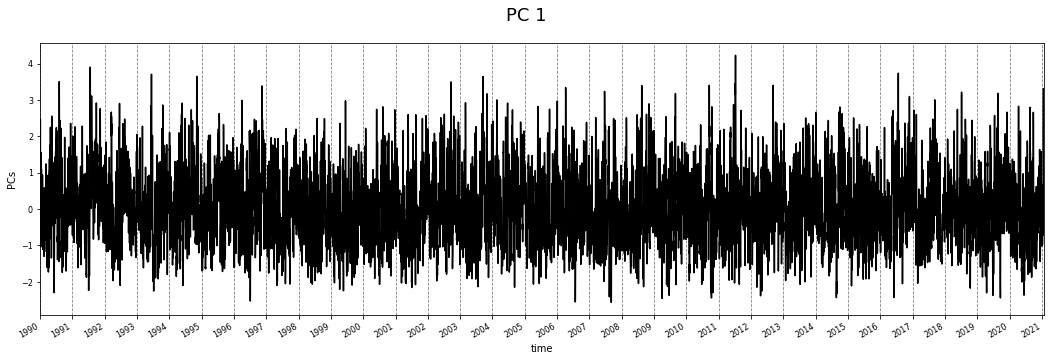


 3 PCs (0.98 expl. variance) will be used to train the model!! 



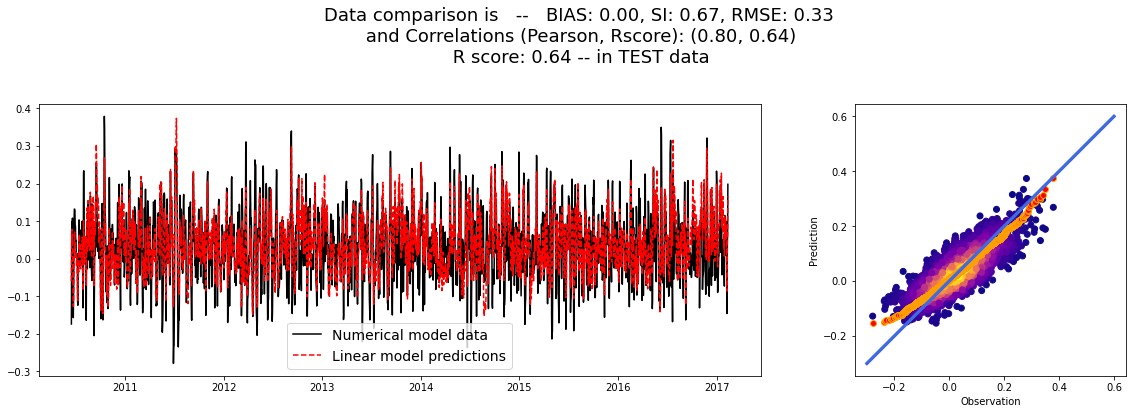

Data comparison is   --   BIAS: 0.00, SI: 0.67, RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 2 in site 200 ......                         

 pca_params = {'calculate_gradient': False, 'winds': False, 'time_lapse': 2, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (0, 0, 1, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculated PCs matrix with shape: 
 (11352, 242) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



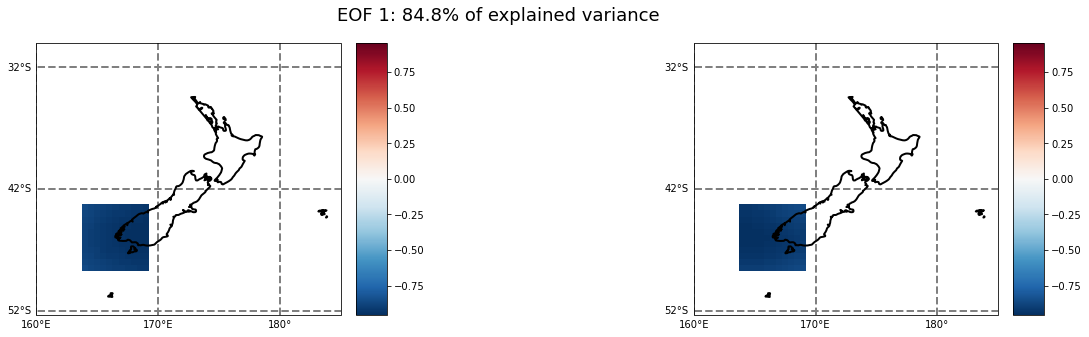

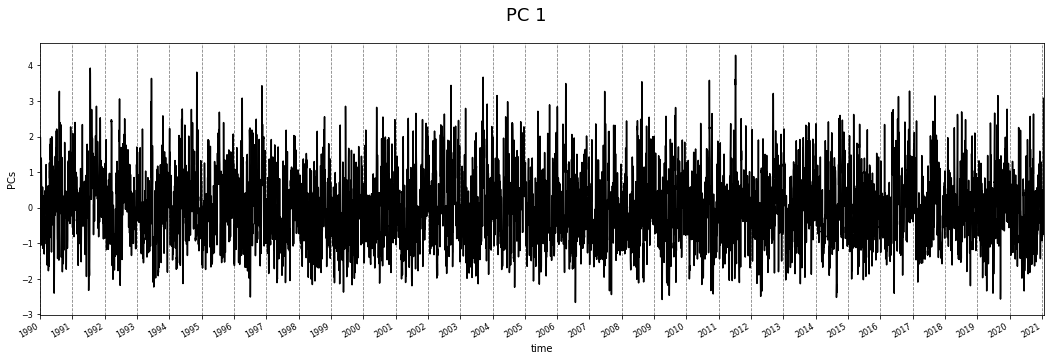


 3 PCs (0.98 expl. variance) will be used to train the model!! 



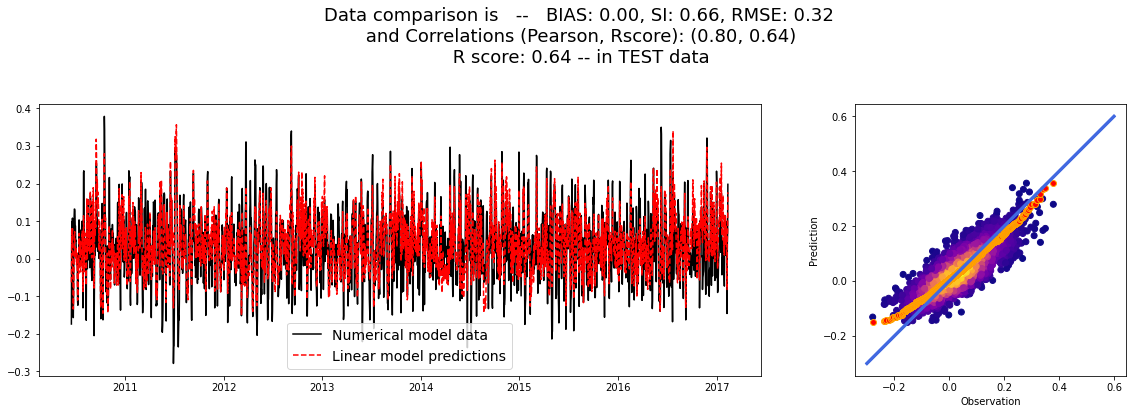

Data comparison is   --   BIAS: 0.00, SI: 0.66, RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 3 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 1, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (1, 0, 0, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 11, 11) 


 calculated PCs matrix with shape: 
 (11353, 242) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



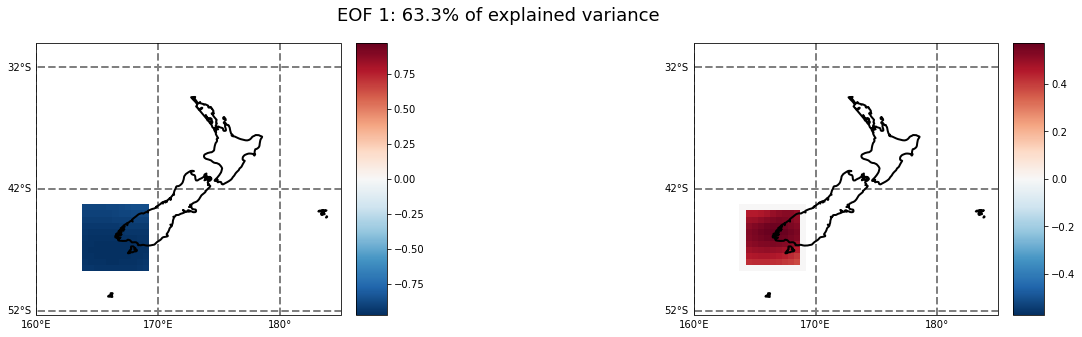

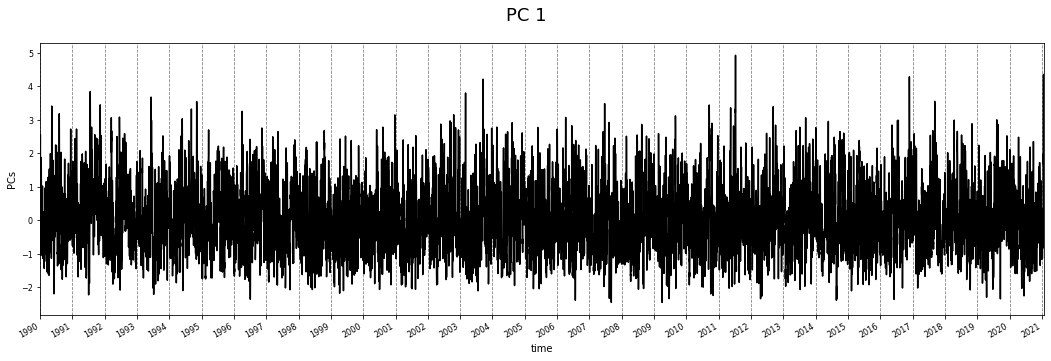


 6 PCs (0.98 expl. variance) will be used to train the model!! 



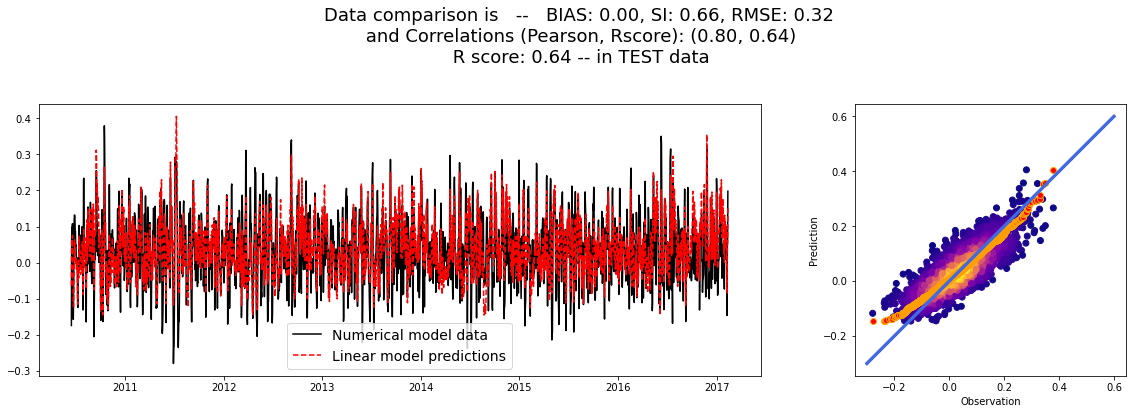

Data comparison is   --   BIAS: 0.00, SI: 0.66, RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 R score: 0.64 -- in TEST data

 ---------------------------------------------------------                         

 Experiment 4 in site 200 ......                         

 pca_params = {'calculate_gradient': True, 'winds': False, 'time_lapse': 2, 'time_resample': '1D', 'region': ('local', (2.6, 2.6))} 

 linear_model_params = {'train_size': 0.7, 'percentage_PCs': 0.98}                         

 and iteration with indexes = (1, 0, 1, 0, 0, 0, 0)                         

 ---------------------------------------------------------
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 11, 11) 


 calculated PCs matrix with shape: 
 (11352, 484) 


 plotting 1 components with 4 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



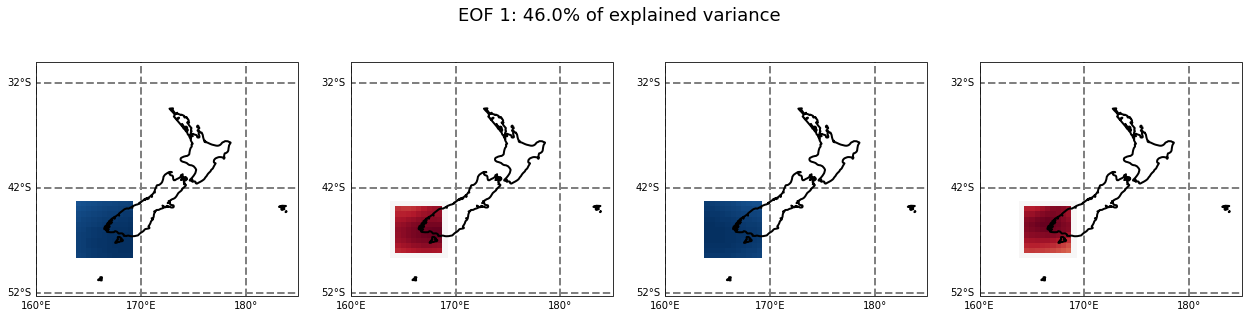

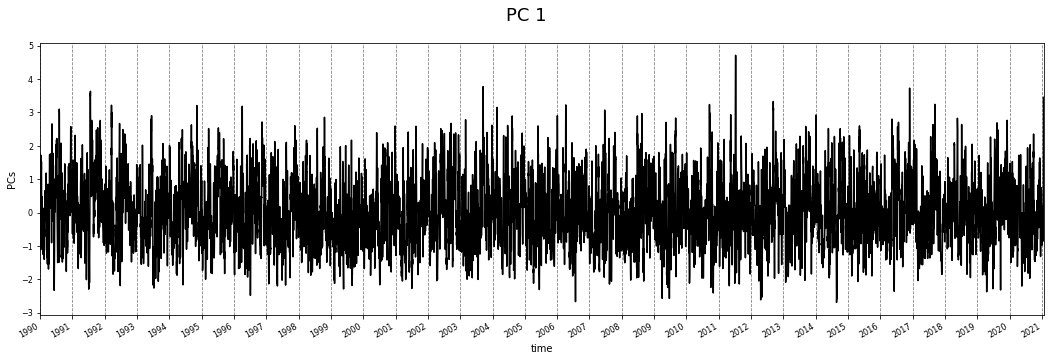


 11 PCs (0.98 expl. variance) will be used to train the model!! 



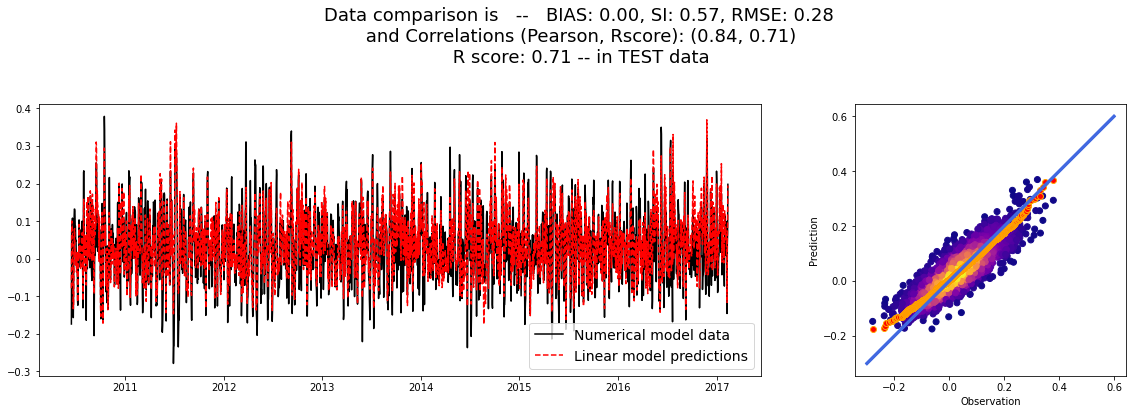

Data comparison is   --   BIAS: 0.00, SI: 0.57, RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 R score: 0.71 -- in TEST data

 -------------------------------------------------------------------             

 All the models and in all the sites have been correctly calculated!!             

 with a final mean stats (in the sites) with the following shape...             

 BIAS, SI, RMSE, Pearson ans Spearman coorelations and the R2 score 

 [[[[[[[[0.62499916 0.04997592 0.00397023 0.22454727 0.04161851
        0.00397023 0.07084357 0.00715127 0.29112947 0.49512507
        0.00277956 0.67863071 0.33072812 0.79064576 0.78055298
        0.62426221]]]]]




   [[[[[0.6288406  0.04961918 0.00393291 0.21476535 0.04092439
        0.00393291 0.07050871 0.0072112  0.29089958 0.48562301
        0.00280594 0.6723523  0.32908966 0.79308604 0.78465743
        0.62809195]]]]]]]






 [[[[[[[0.62633364 0.04988318 0.00395583 0.21989068 0.04165214
        0.00395583 0.06914472 0.006893

In [5]:
# run all the models
exp_parameters, exp_mean_parameters = experiment.execute_cross_model_calculations(
    verbose=True, plot=True # plot logs when computing the models
)

Finally, we can save the results, using the following function:

```python
def save_final_results(to_save_name: str = 
    '../data/statistics/experiments/experiment_linear_final.nc'):
    
    """
        This function saves the results in netCDF4 format
    """
    
    sites_datasets = [] # save all xarray.Dataset's in sites
    for site,exp_metrics_site in zip(experiment.ss_sites,exp_parameters):
        site_metrics = {}
        for im,metric in enumerate(experiment.model_metrics):
            site_metrics[metric] = (
                ('grad','winds','tlapse','tresample','region','tsize','perpcs'),
                exp_metrics_site[:,:,:,:,:,:,:,im]) 
        sites_datasets.append(xr.Dataset(site_metrics).expand_dims(
            {'site':[site]}
        ))
    experiment_metrics = xr.concat(sites_datasets,dim='site')
    experiment_metrics.to_netcdf(to_save_name)
```